# Data Analysis

In this notebook, we load the framewise displacement data and perform some exploratory data analysis by generating some visualizations of the data.

In [1]:
# add modules to path
import sys
sys.path.insert(1, '../src')

# library imports
import torch
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# project imports
import data_processing as dp
import train_eval as te
import models_nn as mnn

# autoreload all modules
%load_ext autoreload
%autoreload 2

## Setup Training and Load Data

In [2]:
# training device
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
# Load the data from the .npz file
data_dict_ppmi, pd_keys, control_keys = dp.load_ppmi_data()
data_dict_hcp = dp.load_hcp_data()

Loaded 320/364 PD subjects and 44/88 Control subjects
Loaded 724 run-01 subject combinations


## Preprocess / Balance Data

In [57]:
# ----------------------- Hyper-parameters ----------------------- #
MAX_LEN = 200  # truncate / zero-pad sequences to this length
BATCH_SIZE = 16
EPOCHS = 200
LR = 4e-4
RNG_SEED = 101

random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

In [67]:
# Create balanced dataset: Controls = PD patients
balanced_pd_dataset, info = dp.create_balanced_pd_classification_dataset(
    data_dict_ppmi, pd_keys, control_keys, data_dict_hcp,
    feature_idx=1,  # RMSD
    harmonization_method='quantile_matching',
    balance_strategy='match_pd'  # Total controls = number of PD patients
)

print(f"Dataset size: {len(balanced_pd_dataset)}")
print(f"Balance ratio: {info['balance_ratio']:.1f}:1 (Controls:PD)")

# Train your model
train_loader, val_loader = te.train_val_split(
    balanced_pd_dataset, val_size=0.2, random_state=RNG_SEED, batch_size=BATCH_SIZE
)

Creating balanced PD classification dataset:
  PPMI PD patients: 320
  PPMI controls: 44
  HCP available: 724
  Strategy: match_pd
  PPMI controls to use: 44
  HCP samples to use: 276
  Total controls: 320
  PD patients: 320
  Final ratio (Controls:PD): 1.0:1
  Harmonizing 276 HCP samples to match PPMI distribution...

Created balanced PD classification dataset:
  Total controls: 320 (PPMI: 44, HCP harmonized: 276)
  Total PD: 320
  Total samples: 640
  Class balance ratio: 1.00:1 (Controls:PD)
  Harmonization method: quantile_matching
Dataset size: 640
Balance ratio: 1.0:1 (Controls:PD)


## Train

Starting training for 200 epochs...
Progress updates every 5 epochs.
Epoch 200/200 | Loss: 0.3353 | Val Acc: 0.750 | Bal Acc: 0.750 | AUC: 0.822 | LR: 0.000400
Training completed!

=== FINAL VALIDATION METRICS ===
Accuracy: 0.750
Balanced Accuracy: 0.750
AUC: 0.822
Sensitivity: 0.742
Specificity: 0.758

=== FINAL VALIDATION METRICS ===
Accuracy: 0.750
Balanced Accuracy: 0.750
AUC: 0.822
Sensitivity: 0.742
Specificity: 0.758


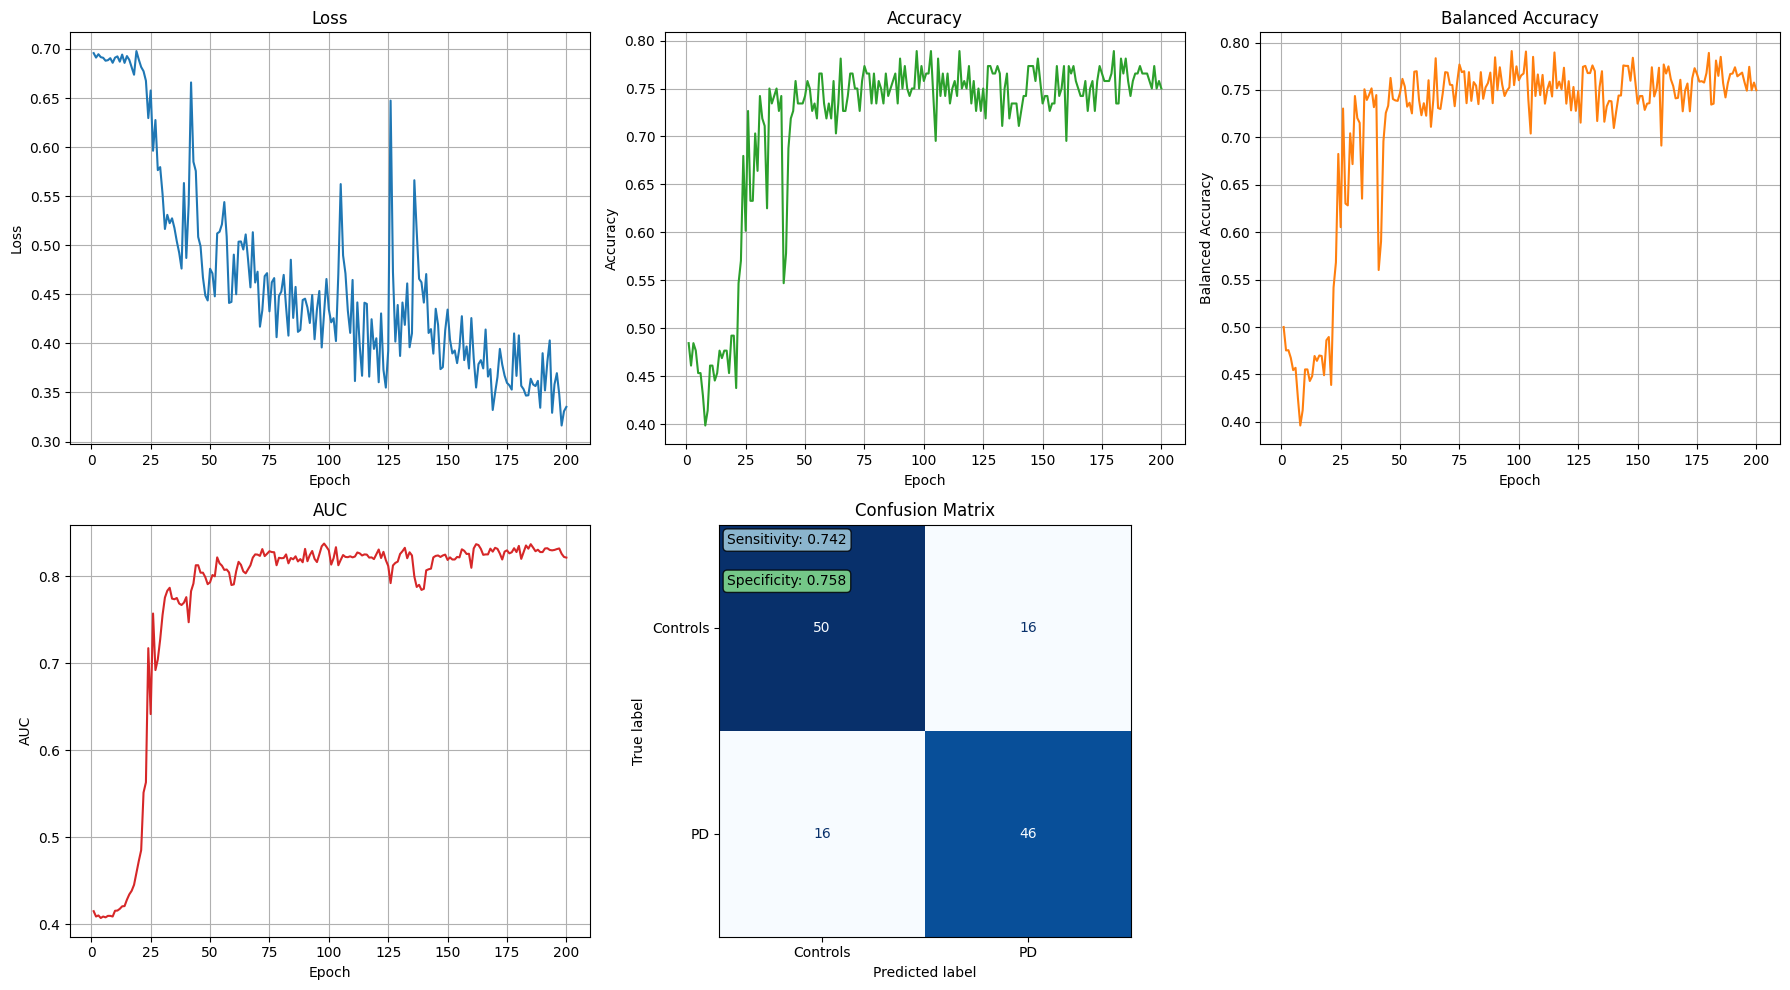

Starting training for 200 epochs...
Progress updates every 5 epochs.
Epoch 200/200 | Loss: 0.6722 | Val Acc: 0.586 | Bal Acc: 0.592 | AUC: 0.549 | LR: 0.000400
Training completed!

=== FINAL VALIDATION METRICS ===
Accuracy: 0.586
Balanced Accuracy: 0.592
AUC: 0.549
Sensitivity: 0.774
Specificity: 0.409

=== FINAL VALIDATION METRICS ===
Accuracy: 0.586
Balanced Accuracy: 0.592
AUC: 0.549
Sensitivity: 0.774
Specificity: 0.409


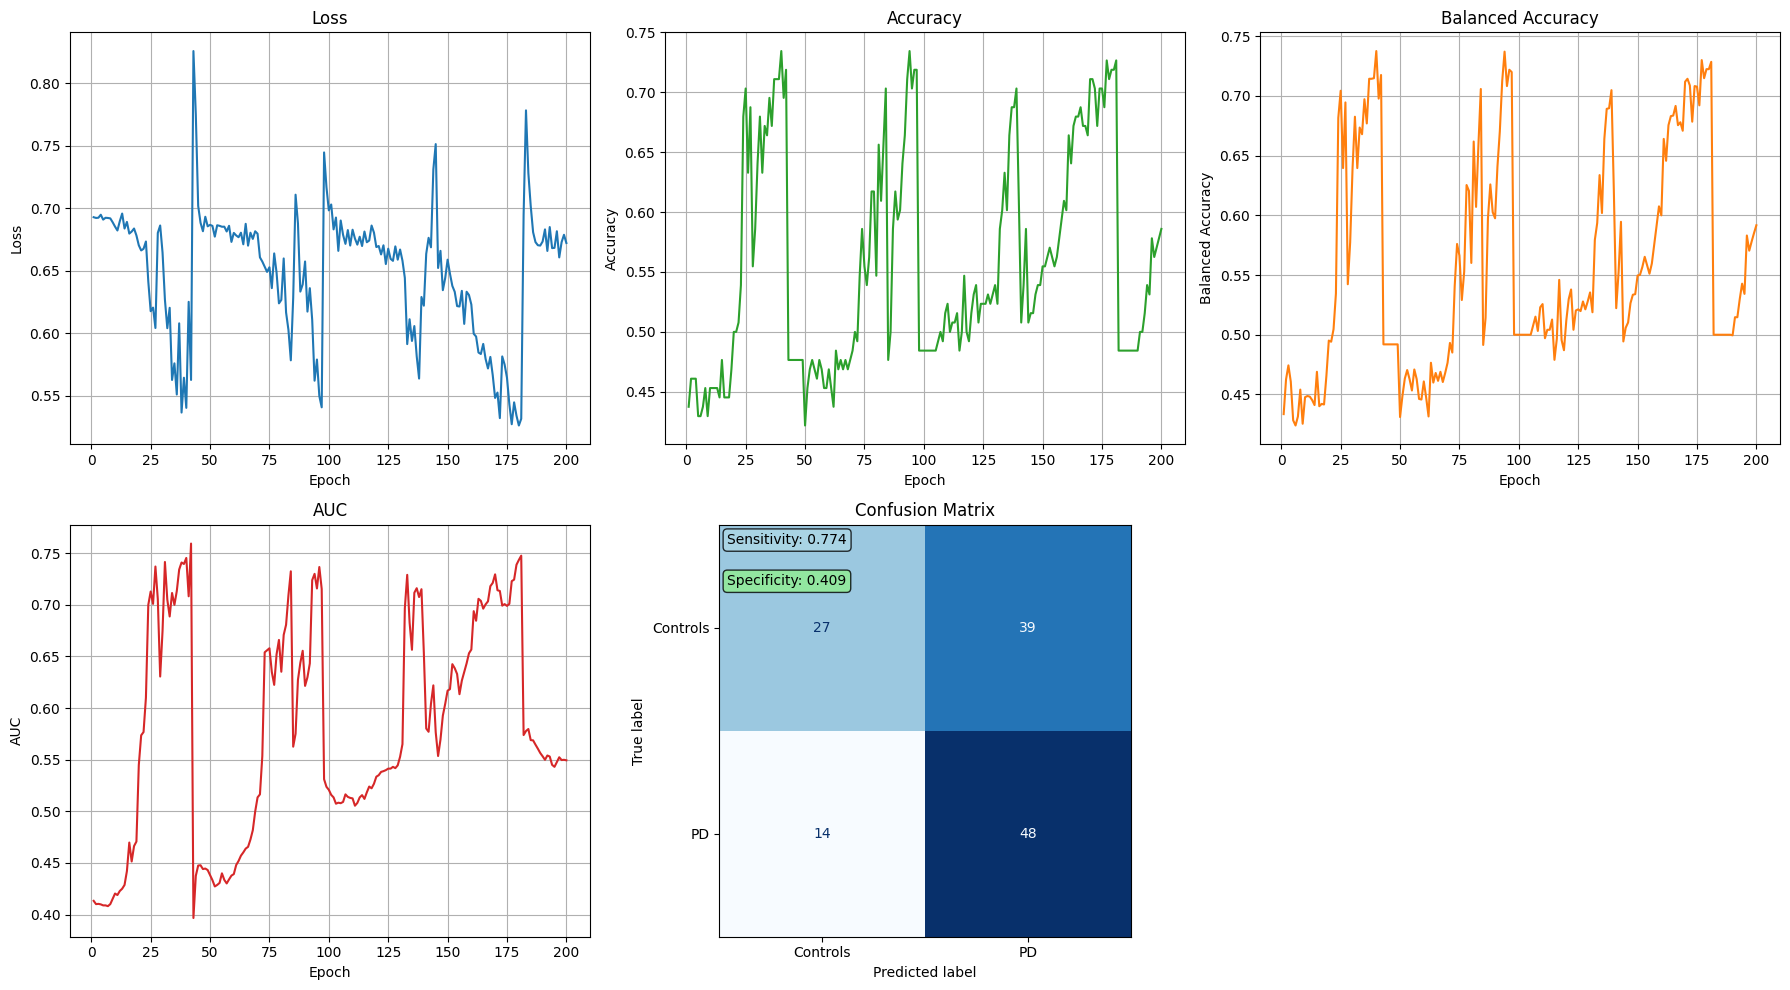

In [74]:
# "GRU": mnn.RNNClassifier(cell="gru"),
# "LSTM": mnn.RNNClassifier(cell="lstm"),
# "Transformer": mnn.TransformerClassifier()

gru = mnn.RNNClassifier(cell="gru")
lstm = mnn.RNNClassifier(cell="lstm")
transformer = mnn.TransformerClassifier()

history_gru = te.train_quiet(
    gru, train_loader, val_loader,
    device=DEVICE, epochs=200, lr=LR, plot=True, 
    class_names=["Controls", "PD"], print_every=5
)

history_lstm = te.train_quiet(
    lstm, train_loader, val_loader,
    device=DEVICE, epochs=200, lr=LR, plot=True, 
    class_names=["Controls", "PD"], print_every=5
)

In [75]:
validation_results = te.evaluate_val_harmonized_controls_separately(lstm, val_loader, DEVICE)

=== VALIDATION SET HARMONIZED CONTROL EVALUATION ===
Validation set size: 128
Validation set breakdown:
  PPMI Controls: 15
  HCP Harmonized Controls: 51
  PPMI PD: 62

PPMI Controls in Validation (n=15):
  Accuracy: 0.400
  Specificity: 0.400
  False Positive Rate: 0.600

HCP Harmonized Controls in Validation (n=51):
  Accuracy: 0.412
  Specificity: 0.412
  False Positive Rate: 0.588

=== VALIDATION CONTROL SOURCE COMPARISON ===
PPMI Control FPR: 0.600
HCP Harmonized Control FPR: 0.588
FPR Difference (HCP - PPMI): -0.012
✅  Similar validation FPRs - good harmonization!

PPMI PD in Validation (n=62) [reference]:
  Accuracy: 0.774
  Sensitivity: 0.774


/afs/cs.stanford.edu/u/karanps/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/afs/cs.stanford.edu/u/karanps/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/afs/cs.stanford.edu/u/karanps/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Starting training for 200 epochs...
Progress updates every 5 epochs.
Epoch 200/200 | Loss: 0.6183 | Val Acc: 0.633 | Bal Acc: 0.632 | AUC: 0.674 | LR: 0.000400
Training completed!

=== FINAL VALIDATION METRICS ===
Accuracy: 0.633
Balanced Accuracy: 0.632
AUC: 0.674
Sensitivity: 0.613
Specificity: 0.652

=== FINAL VALIDATION METRICS ===
Accuracy: 0.633
Balanced Accuracy: 0.632
AUC: 0.674
Sensitivity: 0.613
Specificity: 0.652


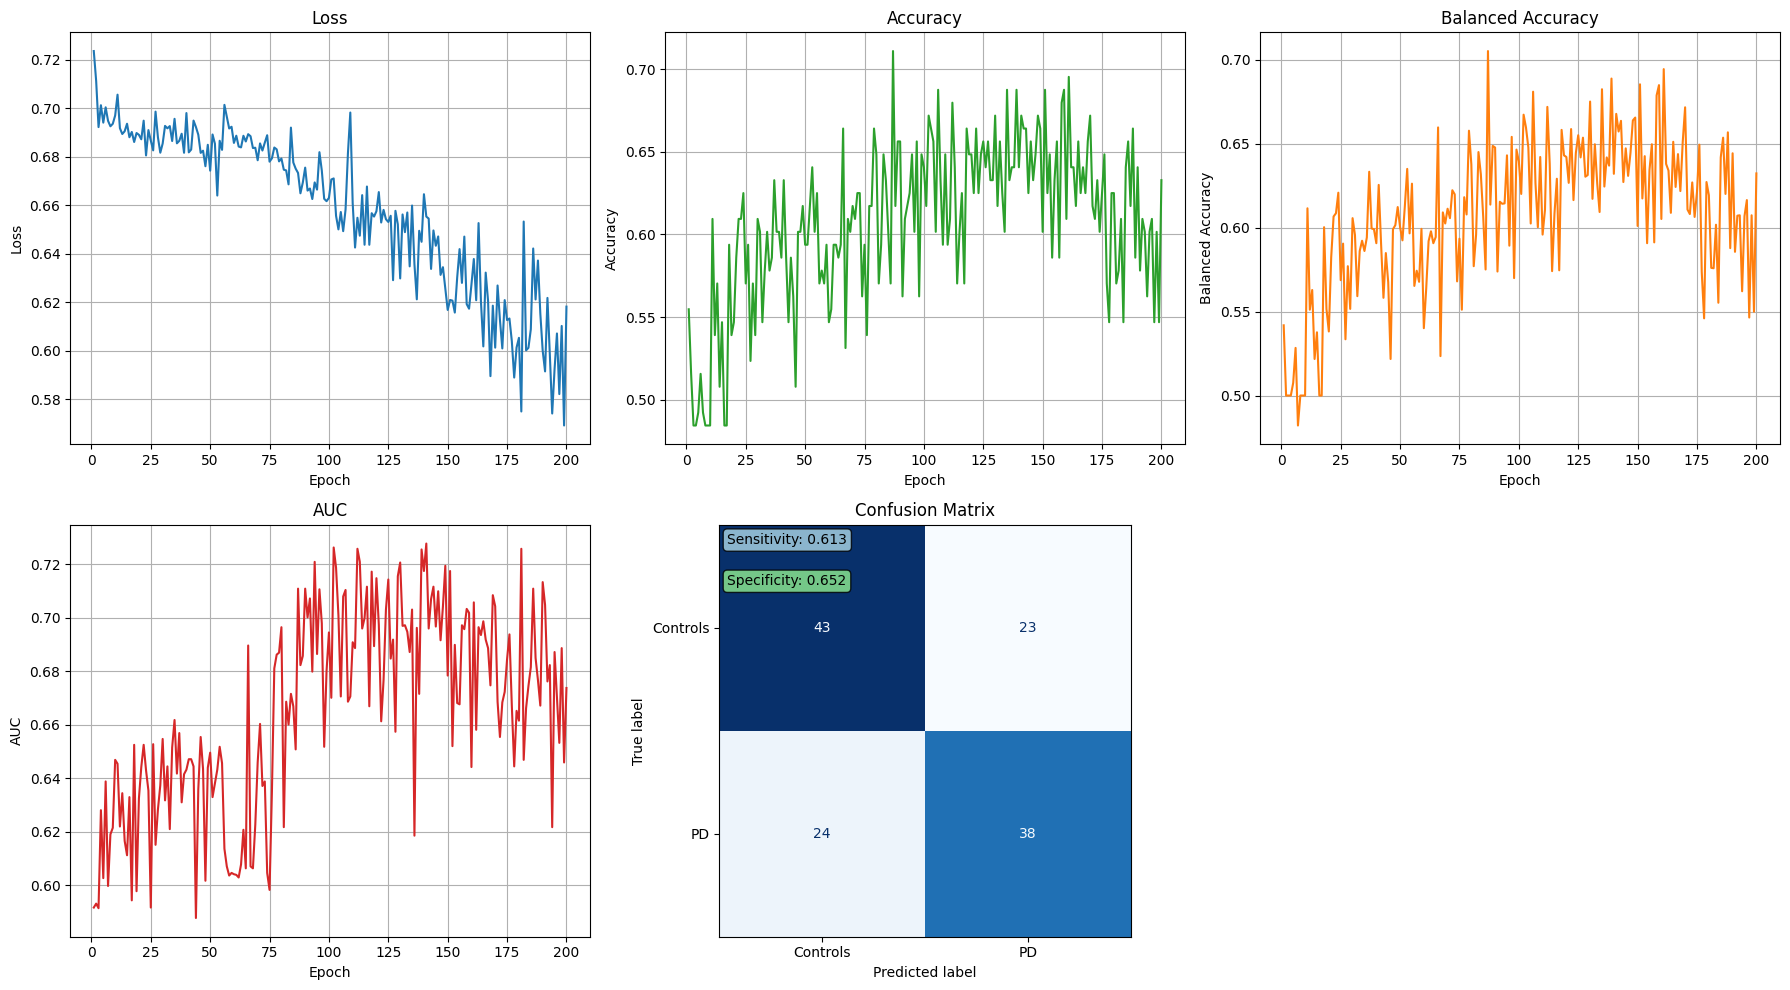

In [77]:
# "GRU": mnn.RNNClassifier(cell="gru"),
# "LSTM": mnn.RNNClassifier(cell="lstm"),
# "Transformer": mnn.TransformerClassifier()

transformer = mnn.TransformerClassifier()

history = te.train_quiet(
    transformer, train_loader, val_loader,
    device=DEVICE, epochs=EPOCHS, lr=LR, plot=True, 
    class_names=["Controls", "PD"], print_every=5
)

In [55]:
validation_results = te.evaluate_val_harmonized_controls_separately(transformer, val_loader, DEVICE)

=== VALIDATION SET HARMONIZED CONTROL EVALUATION ===
Validation set size: 128
Validation set breakdown:
  PPMI Controls: 15
  HCP Harmonized Controls: 51
  PPMI PD: 62

PPMI Controls in Validation (n=15):
  Accuracy: 0.267
  Specificity: 0.267
  False Positive Rate: 0.733

HCP Harmonized Controls in Validation (n=51):
  Accuracy: 0.255
  Specificity: 0.255
  False Positive Rate: 0.745

=== VALIDATION CONTROL SOURCE COMPARISON ===
PPMI Control FPR: 0.733
HCP Harmonized Control FPR: 0.745
FPR Difference (HCP - PPMI): 0.012
✅  Similar validation FPRs - good harmonization!

PPMI PD in Validation (n=62) [reference]:
  Accuracy: 0.806
  Sensitivity: 0.806


/afs/cs.stanford.edu/u/karanps/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/afs/cs.stanford.edu/u/karanps/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/afs/cs.stanford.edu/u/karanps/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [1]:
# transformer = mnn.TransformerClassifierWithCustomAttention()

# history = te.train_quiet(
#     transformer, train_loader, val_loader,
#     device=DEVICE, epochs=EPOCHS, lr=LR, plot=True, 
#     class_names=["Controls", "PD"], print_every=5
# )

Debug: attention shape = (200, 200)
Debug: attention shape = (200, 200)
Debug: attention shape = (200, 200)
Debug: attention shape = (200, 200)


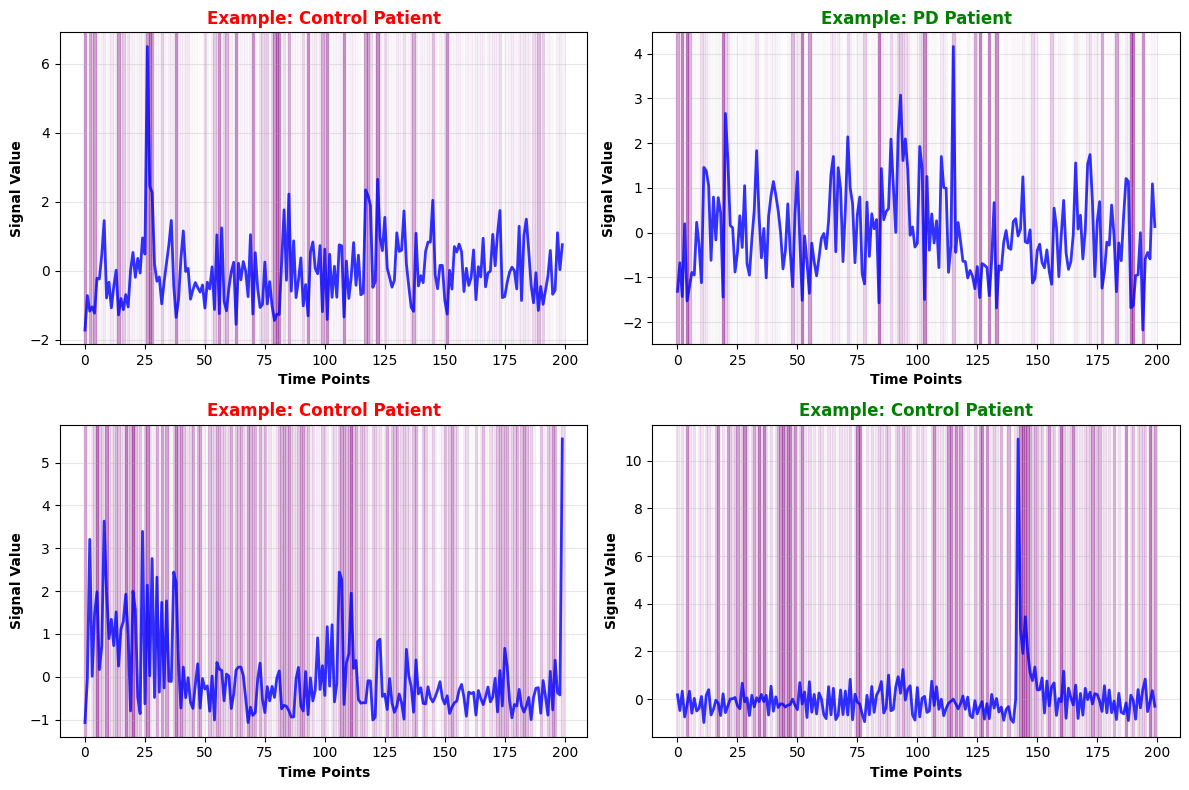

🔍 Transformer Attention Visualization
Purple background intensity = attention weight
Darker purple = model focuses more on those time points


In [37]:
te.plot_transformer_attention(transformer, val_loader, DEVICE, 
                             n_examples=4, class_names=["Control", "PD"])

## Dataset Discrimination

In [2]:
# Load data
data_dict_ppmi, pd_keys, control_keys = dp.load_ppmi_data()
data_dict_hcp = dp.load_hcp_data(run_1_only=True)  # Only run-01

# Create dataset
dataset = dp.MotionDataset(
    datasets=[
        (data_dict_ppmi, pd_keys, 1, 'ppmi'),           # PD
        (data_dict_ppmi, control_keys, 0, 'ppmi'),      # Control  
        # (data_dict_hcp, list(data_dict_hcp.keys())[0:276], 0, 'hcp'),  # HCP (as controls)
    ],
    max_len=MAX_LEN
)

print("Dataset size:", len(dataset))

train_loader, val_loader = te.train_val_split(
        dataset, val_size=0.2, random_state=RNG_SEED, batch_size=BATCH_SIZE
)

In [ ]:
import data_processing as dp
import models_nn as mnn
import train_eval as te
import torch

# Load your data
data_dict_ppmi, pd_keys, control_keys = dp.load_ppmi_data()
data_dict_hcp = dp.load_hcp_data(run_1_only=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run the single-feature discrimination test
results = te.run_single_feature_discrimination_test(
    data_dict_ppmi=data_dict_ppmi,
    control_keys=control_keys,
    data_dict_hcp=data_dict_hcp,
    device=device,
    max_len=200,
    epochs=100,
    batch_size=16,
    random_state=42
)

## Quantile Matching Tests

In [4]:
# Method 1: Quantile matching (most robust)
harmonized_dataset = dp.create_harmonized_dataset(
    data_dict_ppmi, control_keys, data_dict_hcp,
    harmonization_method='quantile_matching'
)

print("Dataset size:", len(harmonized_dataset))

train_loader, val_loader = te.train_val_split(
        harmonized_dataset, val_size=0.2, random_state=RNG_SEED, batch_size=BATCH_SIZE
)

te.train(
    mnn.TransformerClassifier(), train_loader, val_loader,
    device=DEVICE, epochs=EPOCHS*4, lr=LR, plot=True, class_names=["PPMI Controls", "HCP"])

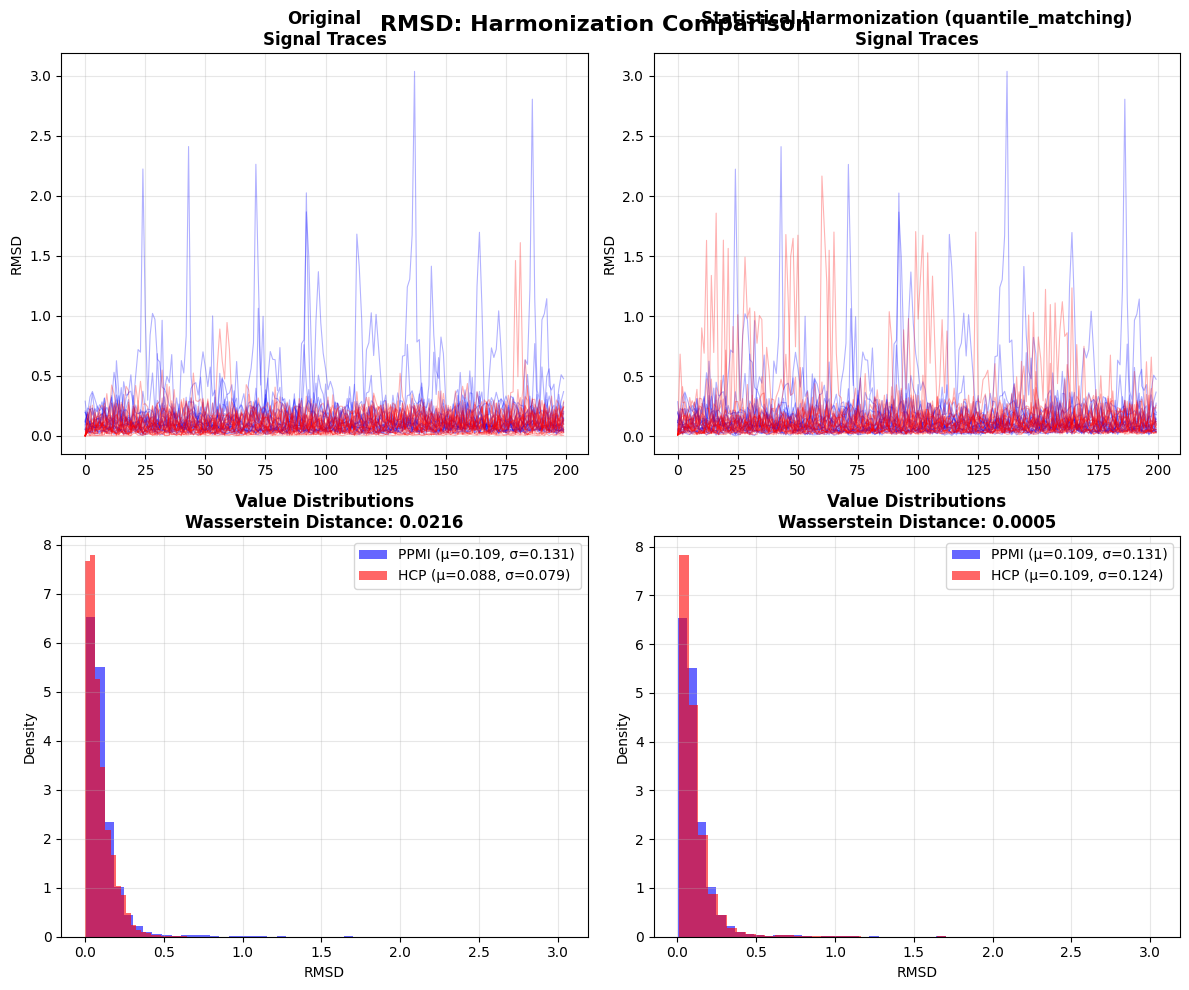

Summary Statistics:

Original:
  Mean difference: 0.0216
  Std ratio (PPMI/HCP): 1.644
  Wasserstein distance: 0.0216

Statistical Harmonization (quantile_matching):
  Mean difference: 0.0004
  Std ratio (PPMI/HCP): 1.051
  Wasserstein distance: 0.0005


In [ ]:
# Test quantile matching (usually most effective)
dp.plot_harmonization_comparison(
    data_dict_ppmi, control_keys, data_dict_hcp,
    feature_idx=1,
    harmonization_method='quantile_matching'
)

In [ ]:
# Create balanced dataset: Controls = PD patients
balanced_pd_dataset, info = dp.create_balanced_pd_classification_dataset(
    data_dict_ppmi, pd_keys, control_keys, data_dict_hcp,
    feature_idx=1,  # RMSD
    harmonization_method='quantile_matching',
    balance_strategy='match_pd'  # Total controls = number of PD patients
)

print(f"Dataset size: {len(balanced_pd_dataset)}")
print(f"Balance ratio: {info['balance_ratio']:.1f}:1 (Controls:PD)")

# Train your model
train_loader, val_loader = te.train_val_split(
    balanced_pd_dataset, val_size=0.2, random_state=RNG_SEED, batch_size=BATCH_SIZE
)

te.train(
    mnn.TransformerClassifier(), train_loader, val_loader,
    device=DEVICE, epochs=EPOCHS*5, lr=LR / 5, plot=True, 
    class_names=["Controls", "PD"]
)